In [1]:
import theano
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-21 15:59:49.718969
numcores: 40


In [2]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [3]:
# Working model, inferring mus 
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(beta))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),-5,15,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [4]:
trace = pm.sample(draws=500,tune=500,cores=8,init='auto',n_init=20,model=model)
print(pm.summary(trace));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [mu4, mu3, mu2, mu1, mu0, beta, alpha]
Sampling 8 chains, 1,038 divergences: 100%|██████████| 8000/8000 [36:35<00:00,  3.64draws/s]
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.09344373293852881, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There 

          mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha    0.399  0.339   0.044    0.879      0.071    0.051      23.0    23.0   
beta[0]  0.378  0.257   0.000    0.680      0.090    0.066       8.0     8.0   
beta[1]  0.871  0.236   0.334    1.000      0.083    0.061       8.0     8.0   
beta[2]  0.697  0.351   0.004    1.000      0.096    0.069      14.0    14.0   
beta[3]  0.821  0.259   0.234    1.000      0.027    0.021      92.0    74.0   
beta[4]  0.703  0.306   0.085    1.000      0.044    0.032      49.0    47.0   
w[0]     0.378  0.257   0.000    0.680      0.090    0.066       8.0     8.0   
w[1]     0.494  0.164   0.315    0.680      0.057    0.042       8.0     8.0   
w[2]     0.084  0.218   0.000    0.662      0.076    0.056       8.0     8.0   
w[3]     0.040  0.106   0.000    0.327      0.037    0.027       8.0     8.0   
w[4]     0.000  0.002   0.000    0.000      0.000    0.000      59.0    59.0   
mu0[0]   3.962  3.089   0.520    7.235  

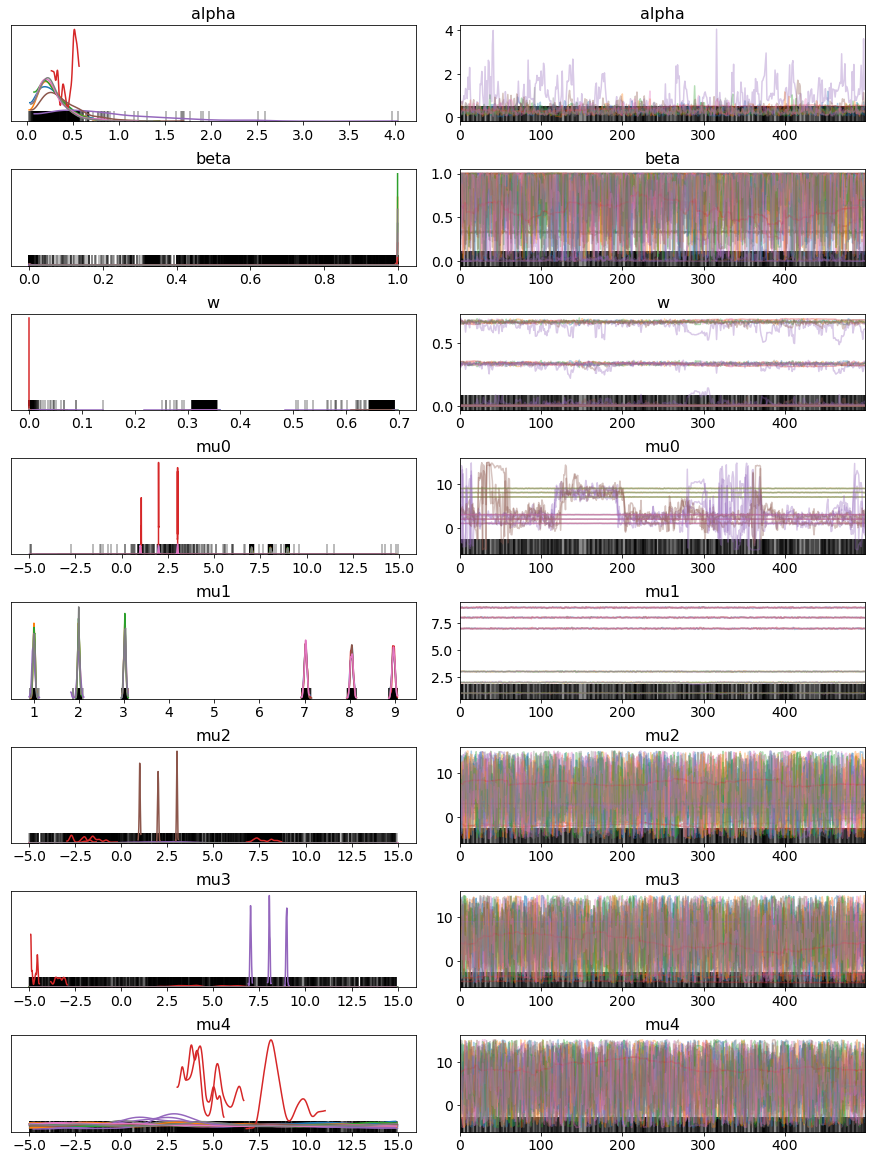

In [5]:
pm.traceplot(trace);

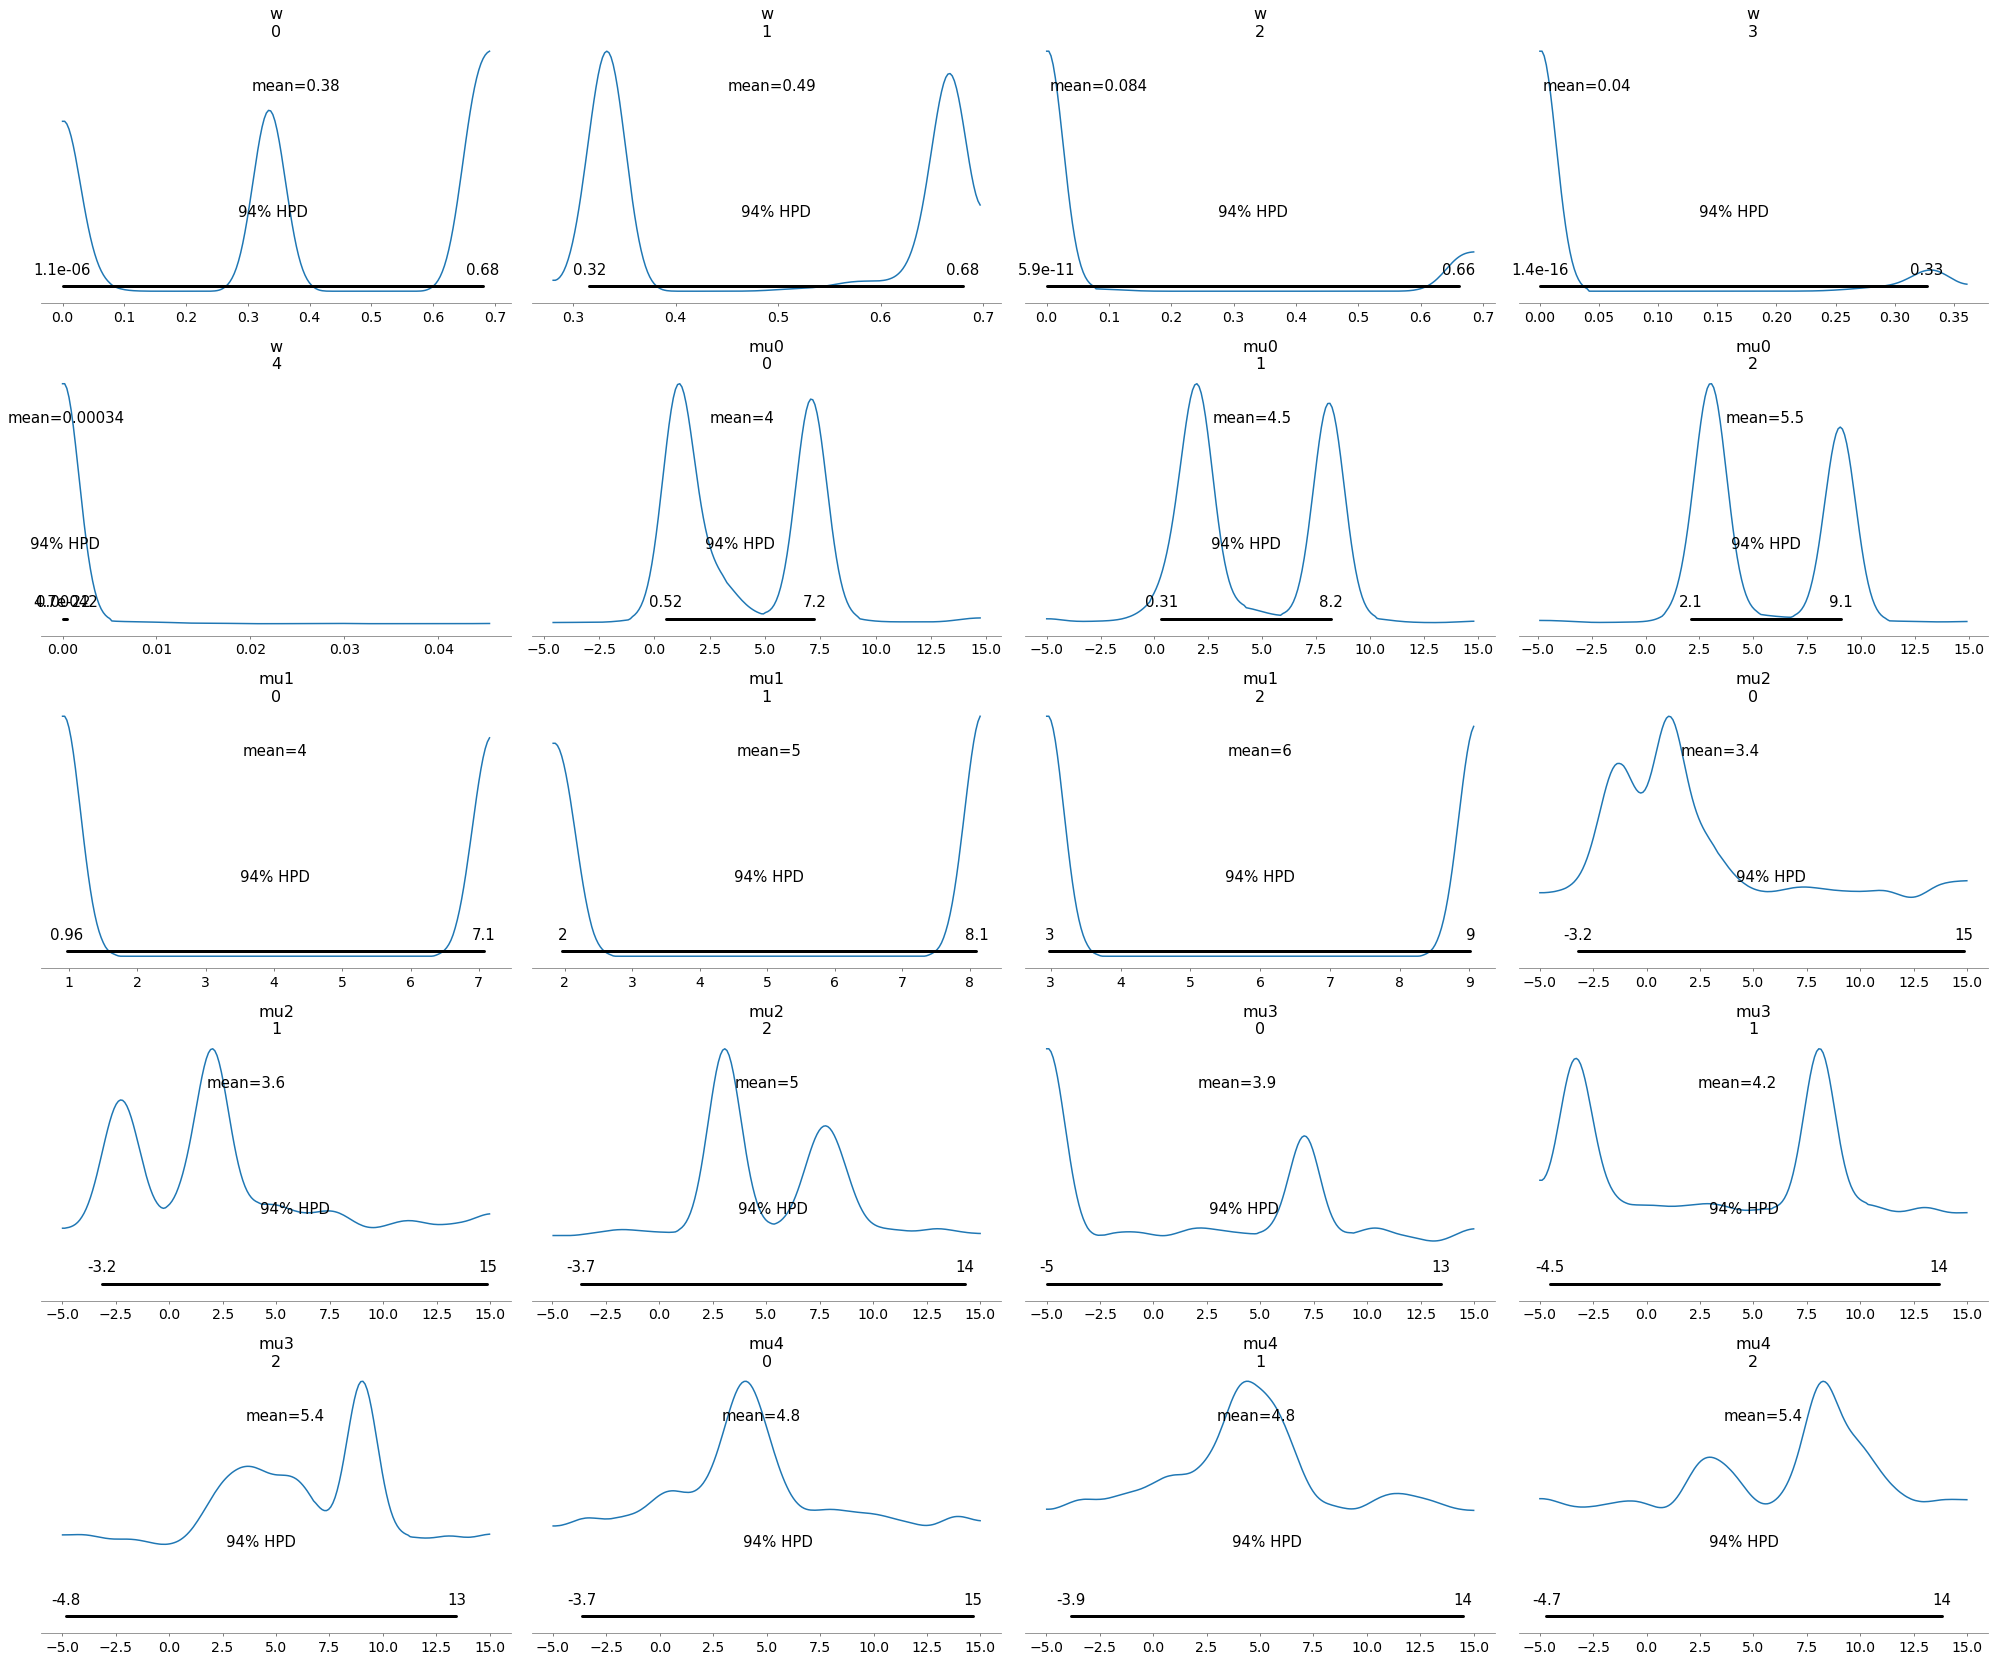

In [6]:
pm.plot_posterior(data=trace,var_names=['w','mu0','mu1','mu2','mu3','mu4']);
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

In [7]:
t_finish=now()

In [8]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 0:39:38.864286


In [9]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [10]:
#with model:
#    trace = pm.find_MAP()